## Exploring the impact of more human raters

In this notebook, we show that: 

1. As we use more and more human raters, the average of the scores assigned by said raters approaches the true score.
2. When evaluating a given automated system against an increasing number of human raters, the values of the conventional agreement metrics approach values that would be computed if that same system were to be evaluated against the true score.

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns

from functools import partial
from matplotlib import pyplot as plt
from pathlib import Path
from rsmtool.analyzer import Analyzer
from scipy.stats import pearsonr
from simulation.dataset import Dataset
from simulation.utils import compute_cumulative_mean_for_raters

### Step 1: Setup

To set up the experiment, we first load the dataset we have already created and saved in the `making_the_dataset.ipynb` notebook and use that for this experiment.

For convenience and replicability, we have pre-defined many of the parameters that are used in our notebooks and saved them in the file `settings.json`. We load this file below.

In [2]:
# load the dataset file
dataset = Dataset.from_file('../data/default.dataset')

# let's remind ourselves what the dataset looks like
print(dataset)

Dataset (10000 responses, scores in [1, 6], 4 rater categories, 50 raters/category, 5 system categories, 5 systems/category)


In [3]:
# load the experimental settings file
experiment_settings = json.load(open('settings.json', 'r'))

In [4]:
# now get the data frames for our loaded dataset
df_scores, df_rater_metadata, df_system_metadata = dataset.to_frames()

### Step 2: Compute cumulative averages & differences with true score

The next step is to compute the cumulative mean scores for each response in the dataset as we increase the number of human raters, per category. So, basically, within each category, we want to compute 50 (=number of raters per category) scores for each response in the dataset: the average score with 1 human raters, the average score with 2 human raters, the average score with 3 human raters and so on. 

In [5]:
# define a partial function that we can easily apply to get the cumulative
# average scores (adding one rater at a time) for each response in the 
# simulated dataset
cumulative_mean_computer = partial(compute_cumulative_mean_for_raters, df_scores)

# now apply this partial function to the rater IDs in each category
df_cumulative_means_per_category = df_rater_metadata.groupby('rater_category')['rater_id'].apply(cumulative_mean_computer)

Next, we compute how far each of the cumulative averages is from the true score within each category. 

In [6]:
# initialize an empty list that will hold the true score difference values for each rater category
difference_dfs = []

# iterate over each rater category
for rater_category in dataset.rater_categories:

    # compute the difference between each set of cumulative mean scores for this category and the true scores
    df_difference = df_cumulative_means_per_category.loc[rater_category].apply(lambda column: column - df_scores['true'])
    
    # save this data frame with the differences in the list
    difference_dfs.append(df_difference)
    
# now create a single data frame with the same structure as the cumulative mean scores frame above
df_cumulative_true_differences_per_category = pd.concat(difference_dfs, keys=dataset.rater_categories, names=['rater_category'])

Next, we plot a boxplot to show how the differences with the true scores change with an increasing number of raters included in the cumulative average rater score.

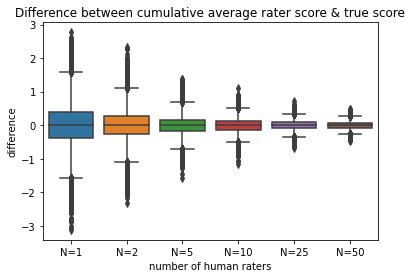

In [7]:
# we use an experimental setting that pre-defines the x axis stops
rater_steps = experiment_settings['key_steps_n_raters']

# subset the difference data frame to only these number of raters and make the boxplot
ax = sns.boxplot(data=df_cumulative_true_differences_per_category[[f"N={rater_step}" for rater_step in rater_steps]])
ax.set_title('Difference between cumulative average rater score & true score')
ax.set_xlabel('number of human raters')
ax.set_ylabel('difference')
plt.show()

The boxplot clearly shows that the cumulative average rater score for each hypothetical response in our dataset gets closer to the true score as the number of raters included in the cumulative average increases.

Another way to look at this is to look at the correlation between the cumulative average rater scores and the true scores.

In [8]:
# initialize an empty list that will hold the true score correlations for each rater category
correlations = []

# iterate over each rater category
for rater_category in dataset.rater_categories:

    # compute the correlation between each set of cumulative mean scores for this category and the true scores
    correlations_for_this_category = df_cumulative_means_per_category.loc[rater_category].apply(lambda column: pearsonr(column, df_scores['true'])[0])
    
    # we want the index to be numbers, not the strings `N=n`
    correlations_for_this_category.index = correlations_for_this_category.index.str.replace('N=', '').astype(int)

    # we also want the rater category as a column in there
    correlations_for_this_category['rater_category'] = rater_category
    
    # save this data frame with the differences in the list
    correlations.append(correlations_for_this_category)

# now combine all of these correlation values into a single data frame
df_cumulative_true_correlations_with_categories = pd.DataFrame(correlations)

# Now make a longer version of the correlations data frame that's more amenable to plotting
df_cumulative_true_correlations_with_categories_long = df_cumulative_true_correlations_with_categories.melt(id_vars=['rater_category'],
                                                                                                            var_name='num_raters',
                                                                                                            value_name='correlation')

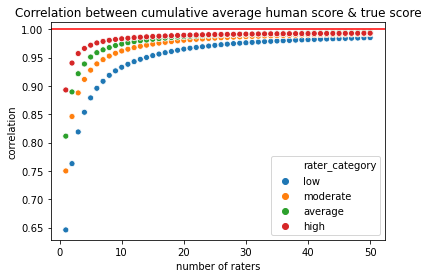

In [9]:
# now plot a scatterplot that shows these correlation values
ax = sns.scatterplot(x='num_raters', 
                     y='correlation',
                     hue='rater_category',
                     data=df_cumulative_true_correlations_with_categories_long)
ax.axhline(1, color='red')
ax.set_xlabel("number of raters")
ax.set_ylabel("correlation")
ax.set_title("Correlation between cumulative average human score & true score");
plt.show()

## Step 3 : Evaluating a system against increasing number of raters

Next, we will examine the impact of using multiple human raters on the conventional agreement metrics used to evaluate a pre-determined simulated system in our dataset. We focus on the three agreement metrics that are used most often to score automated systems: 
1. Pearson's correlation
2. Quadratically-weighted kappa
3. Adjusted R^2

In [10]:
# first we get the ID of the pre-determined simulated system in our dataset from the experiment settings file
chosen_system = experiment_settings['sample_system']

# now we can extract out the scores for this specific system
system_scores = df_scores[chosen_system]

# for plotting convenience, let's change the column names to be integers instead of labels like `N=n`
df_cumulative_means_per_category.columns = df_cumulative_means_per_category.columns.str.replace('N=', '').astype(int)

Now, we compute the values of the conventional agreement metrics evaluating the chosen system's scores against each of the cumulative average rater scores, within each category.

In [11]:
# initialize an empty list that will hold the metric values for each rater category
metric_dfs = []

# iterate over each rater category
for rater_category in dataset.rater_categories:
    
    # compute the metric values between each set of cumulative mean scores for this category and the system scores
    df_metrics_for_category = df_cumulative_means_per_category.loc[rater_category].apply(lambda column: Analyzer.metrics_helper(column, system_scores))
    
    # we are only interested in the three standard metrics
    df_metrics_for_category = df_metrics_for_category.loc[['corr', 'R2', 'wtkappa']]
    
    # let's rename the metrics to something more recognizable
    df_metrics_for_category = df_metrics_for_category.rename(index={'wtkappa': 'QWK', 'corr': 'r'})
    
    # let's name the index since that will be useful later
    df_metrics_for_category.index.name = 'metric'

    # save the rater category as a column
    df_metrics_for_category['rater_category'] = rater_category
    
    # save this data frame with the metric values in the list
    metric_dfs.append(df_metrics_for_category)
    
# now create a single data frame with the same structure as the cumulative mean scores frame above
df_cumulative_system_metric_values_per_category = pd.concat(metric_dfs)

In [12]:
# now let's create a longer version of this metric value data frame that's more amenable to plotting
df_cumulative_system_metric_values_per_category = df_cumulative_system_metric_values_per_category.reset_index()
df_cumulative_system_metric_values_per_category_long = df_cumulative_system_metric_values_per_category.melt(id_vars=['rater_category', 'metric'],
                                                                                                            var_name='num_raters')

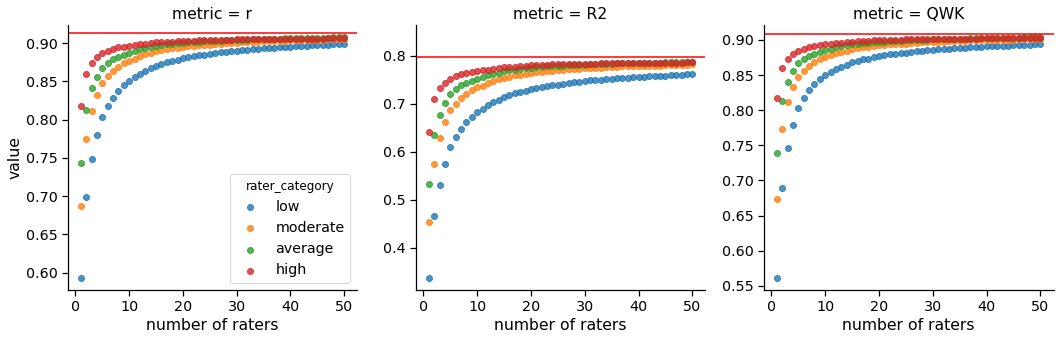

In [13]:
# now let's create the plot showing the value of these metrics
with sns.plotting_context('notebook', font_scale=1.3):
    g=sns.lmplot(x='num_raters',
                 y='value',
                 col='metric',
                 hue='rater_category',
                 data=df_cumulative_system_metric_values_per_category_long,
                 fit_reg=False,
                 hue_order = dataset.rater_categories,
                 col_order=['r', 'R2', 'QWK'], 
                 legend_out=False,
                 sharey=False)

    # let's also add a line to each graph that shows what the value
    # of each metric would be when evaluating the system scores against
    # the simulated true/gold-standard scores in our dataset
    true_system_metric_values = Analyzer.metrics_helper(df_scores['true'], system_scores)
    true_system_metric_values = true_system_metric_values.rename({'corr': 'r', 'wtkappa': 'QWK'})
    axes = g.axes[0]
    for ax in axes:
        metric = ax.get_title().split('=')[1].strip()
        line_height = true_system_metric_values[metric]
        ax.axhline(line_height, color='red')
        ax.set_xlabel('number of raters')
    plt.show()

As the above plots show, as the number of raters increases, their cumulative average approaches the value that one would get by using the true score as the evaluation reference. 